# Logistic Regression
https://realpython.com/logistic-regression-python/

Logistic regression model is based on a sigmoid function that has values very close to either 0 or 1 across most of its domain.
$$\sigma(x) = \frac{1}{1+exp(-x)}$$
The interpretation is that the probability that the output for a given 𝐱 is equal to 1 is
$$p(x) = \sigma(f(x)),$$
where $f(x)$ is a linear function logit
$$f(x) = b_{0}+b_{1}x_{1}+...+b_{r}x_{r}$$
and $b_{i}$ are the estimators of the regression coefficients, which are also called the predicted weights or just coefficients. For each observation 𝑖 = 1, …, 𝑛, the predicted output is 1 if 𝑝(𝐱ᵢ) > 0.5 and 0 otherwise. The threshold doesn’t have to be 0.5, but it usually is.
$$ln(\frac{p(𝐱)}{1-p(𝐱)})=f(𝐱)$$
It implies that 𝑝(𝐱) = 0.5 when 𝑓(𝐱) = 0 and that the predicted output is 1 if 𝑓(𝐱) > 0 and 0 otherwise.

In [7]:
import os
os.chdir('C:/Sereda/Lectures/Springboard/Capstone2_CustomerChurn/')
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import  accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
pd.set_option('display.max_rows', 600)
#from os.path import exists

#### Standardization of continuous variables
Standardization: This technique transforms the data to have a mean of zero and a standard deviation to 1.
Standardization is performed after cutting off on some date, since in reality there will be no access to future data. We will see how to select the strategies based on Gaussian and Non-Gaussian distribution of the features to improve the performance of the Logistic Regression model.
https://towardsdatascience.com/feature-scaling-effectively-choose-input-variables-based-on-distributions-3032207c921f

In [21]:
standardize = False
csv_unscaled = "data/df_20161022_onehot.csv"
csv_standardized = "data/df_20161022_onehot_std.csv"
if not os.path.exists(csv_standardized):
    print("Standardize continuous features")
    df = pd.read_csv(csv_unscaled)
    cols2standardize = ['reg_to_trans_days','num_25_av7','num_50_av7','num_75_av7','num_985_av7','num_100_av7',
                'num_25_av30','num_50_av30','num_75_av30','num_985_av30','num_100_av30',
                'num_25_av90','num_50_av90','num_75_av90','num_985_av90','num_100_av90',
                'num_unq_av7','num_unq_av30','num_unq_av90','total_secs_av7','total_secs_av30','total_secs_av90']
    print(f"Continuous variables to standardize: {len(cols2standardize)}")
    display(df[cols2standardize].head(1))
    scaler = StandardScaler()
    df_std = pd.DataFrame(scaler.fit_transform(df[cols2standardize]), columns=cols2standardize) # standardized continuous variables
    df_nostd = df.drop(cols2standardize, axis=1) # all other variables
    df = pd.concat([df_nostd,pd.DataFrame(df_std)], axis=1) # concatenate columns
    print("with_mean =",scaler.mean_) # =np.mean(df[cols2standardize]); to be re-used in predictions
    print("with_std =",scaler.scale_)
    print("df is standardized (mean = 0, sd = 1), df.shape =",df.shape)
    df.to_csv(csv_standardized, index=False)
else: print("Standardized df exists")

Standardized df exists


#### Import `df`

In [22]:
#df = pd.read_csv('data/df.csv')
#df = pd.read_csv('data/df_20161022_1.csv')
#df = pd.read_csv('data/df_20161022_1.all_onehot.csv')
#df = pd.read_csv('data/df_20161022_1.gender_onehot.featuresmt.csv')
#csv = "data/df_20161022_1.gender_onehot.featuresmt.csv"
if standardize:
    csv = csv_standardized
else:
    csv = csv_unscaled
df = pd.read_csv(csv)
drop_cols = False
if drop_cols:
    df = df.drop(['registration_Month','registration_winter','registration_spring','registration_summer',
              'registration_autumn','registration_DayofMonth','registration_beginOfMonth','registration_middleOfMonth',
             'registration_endOfMonth','registration_DayOfWeek','registration_holiday','registration_weekday',
             'firsttransaction_Month','firsttransaction_winter','firsttransaction_spring','firsttransaction_summer',
             'firsttransaction_autumn','firsttransaction_DayofMonth','firsttransaction_beginOfMonth',
             'firsttransaction_middleOfMonth','firsttransaction_endOfMonth','firsttransaction_DayOfWeek','firsttransaction_holiday',
             'firsttransaction_weekday','reg_to_trans_days1','transaction_Month1','transaction_winter1','transaction_spring1',
             'transaction_summer1','transaction_autumn1','transaction_DayofMonth1','transaction_beginOfMonth1','transaction_middleOfMonth1',
             'transaction_endOfMonth1','transaction_DayOfWeek1','transaction_holiday1','transaction_weekday1']
             ,axis=1)
print("No. of descriptors:",df.shape[1]-1)
print("No. of records:",df.shape[0])
display(df.head())
pd.set_option('display.max_seq_items', None)
print(df.columns)

No. of descriptors: 371
No. of records: 17124


,is_auto_renew,is_cancel,reg_to_trans_days,is_churn,registration_winter,registration_spring,registration_summer,registration_autumn,registration_beginOfMonth,registration_middleOfMonth,...,transaction_DayofMonth_29,transaction_DayofMonth_30,transaction_DayofMonth_31,transaction_DayOfWeek_0,transaction_DayOfWeek_1,transaction_DayOfWeek_2,transaction_DayOfWeek_3,transaction_DayOfWeek_4,transaction_DayOfWeek_5,transaction_DayOfWeek_6
0,0,0,4098,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,4098,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,4098,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,0,4021,1,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,1,0,4021,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


Index(['is_auto_renew', 'is_cancel', 'reg_to_trans_days', 'is_churn',
       'registration_winter', 'registration_spring', 'registration_summer',
       'registration_autumn', 'registration_beginOfMonth',
       'registration_middleOfMonth', 'registration_endOfMonth',
       'registration_holiday', 'registration_weekday',
       'firsttransaction_winter', 'firsttransaction_spring',
       'firsttransaction_summer', 'firsttransaction_autumn',
       'firsttransaction_beginOfMonth', 'firsttransaction_middleOfMonth',
       'firsttransaction_endOfMonth', 'firsttransaction_holiday',
       'firsttransaction_weekday', 'transaction_winter', 'transaction_spring',
       'transaction_summer', 'transaction_autumn', 'transaction_beginOfMonth',
       'transaction_middleOfMonth', 'transaction_endOfMonth',
       'transaction_holiday', 'transaction_weekday', 'num_25_av7',
       'num_50_av7', 'num_75_av7', 'num_985_av7', 'num_100_av7', 'num_unq_av7',
       'total_secs_av7', 'num_25_av30', 'num_50

#### Explanatory and response variables

In [23]:
X = df.drop('is_churn', axis=1) # drop unknown churn
y = df[['is_churn']]
y = np.ravel(y)
#print(y[:5])

#### Quality Metrics

In [56]:
def confusion_matrix_plot(y_actual, y_predicted):
    '''Plot Binary Confusion Matrix for actual and predicted labels'''
    #from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_actual, y_predicted)
    tn = cm[0,0] # true negative count
    fp = cm[0,1] # false positive count
    fn = cm[1,0] # false negative count
    tp = cm[1,1] # true positive count
    print("[[TN, FP], [FN, TP]] =\n",cm) # print confusion matrix
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red') # counts
    plt.show();
    return tn,fp,fn,tp

def metrics(X, y_actual, model, tn,fp,fn,tp):
    '''Quality Metrics'''
    dr = 6 # rounding digits
    y_score = model.predict_proba(X)[:,1] # probabilities of prediction=1
    roc_auc = roc_auc_score(y_actual, y_score)
    #print(f"roc_auc_score = {round(roc_auc,dr)}: Area under ROC curve.")

    y_predicted = model.predict(X)
    accuracy = accuracy_score(y_actual, y_predicted)
    #print(f"Accuracy = {round(accuracy,dr)}: (TN+TP)/(TN+TP+FN+FP): Accuracy: percentage of total items classified correctly")
    # accuracy_nosplit = log_reg_nosplit.score(X, y)
    
    tnr = tn/(tn + fp) # tnr = 1-fpr
    #print(f"TNR = {round(tnr,dr)}: Specificity, selectivity or true negative rate (TNR), proportion of the negative class 0 got correctly classified.")
    fpr = fp/(tn + fp) # fpr = 1-tnr
    #print(f"FPR = {round(fpr,de)} Fall-out or false positive rate (FPR), or Type I Error: proportion of the negative class 0 got incorrectly classified.")

    fnr = fn/(fn + tp) # fnr = 1-tpr
    #print(f"FNR = {round(fnr,dr)}: Type II Error, miss rate or false negative rate (FNR): Proportion of the positive class 1 got incorrectly classified.")
    tpr = tp/(tp + fn) # tpr = 1-fnr
    #print(f"TPR = {round(tpr,dr)}: TP/(TP+FN): Sensitivity, recall, hit rate, or true positive rate (TPR): proportion of the positive class 1 got correctly classified.")
    #print('Recall =', recall_score(y_actual, y_predicted))
    
    precision = tp/(tp+fp) # TP/PP = TP/(TP+FP)
    #print(f"Precision = {round(precision,dr)}: TP/PP = TP/(TP+FP)")
    #print(f"Precision = {round(precision_score(y_actual, y_predicted),dr)}")
    
    f1 = 2*tp/(2*tp+fp+fn)
    #print(f"F1 score = {round(f1,dr)}: F1 score: harmonic mean of precision and recall.")
    #print(f"F1 score = {round(f1_score(y_actual, y_predicted),dr)}: F1 score: harmonic mean of precision and recall.")
    
    MCC = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    #print(f"MCC = {round(MCC,dr)}: Matthews correlation coefficient: accounts for all 4 confusion matrix categories.")
    
    print(f"AUC\tAccur\tTNR\tTPR\tPrecis\tF1\tMCC")
    print(f"%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f" % (roc_auc, accuracy, tnr, tpr, precision, f1, MCC))

def scores_all(X_test, y_test, model):
    '''Quality Metrics: roc_auc, accuracy, tnr, tpr, precision, f1, MCC'''
    y_score = model.predict_proba(X_test)[:,1] # predicted probabilities of y=1
    y_pred = model.predict(X_test) # predicted labels 0,1
    cm = confusion_matrix(y_test, y_pred)
    tn = cm[0,0] # true negative count
    fp = cm[0,1] # false positive count
    fn = cm[1,0] # false negative count
    tp = cm[1,1] # true positive count
    
    roc_auc = roc_auc_score(y_test, y_score)
    #print(f"roc_auc_score = {round(roc_auc,dr)}: Area under ROC curve.")

    y_predicted = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_predicted)
    #print(f"Accuracy = {round(accuracy,dr)}: (TN+TP)/(TN+TP+FN+FP): Accuracy: percentage of total items classified correctly")
    # accuracy_nosplit = log_reg_nosplit.score(X, y)
    
    tnr = tn/(tn + fp) # tnr = 1-fpr
    #print(f"TNR = {round(tnr,dr)}: Specificity, selectivity or true negative rate (TNR), proportion of the negative class 0 got correctly classified.")
    fpr = fp/(tn + fp) # fpr = 1-tnr
    #print(f"FPR = {round(fpr,de)} Fall-out or false positive rate (FPR), or Type I Error: proportion of the negative class 0 got incorrectly classified.")

    fnr = fn/(fn + tp) # fnr = 1-tpr
    #print(f"FNR = {round(fnr,dr)}: Type II Error, miss rate or false negative rate (FNR): Proportion of the positive class 1 got incorrectly classified.")
    tpr = tp/(tp + fn) # tpr = 1-fnr
    #print(f"TPR = {round(tpr,dr)}: TP/(TP+FN): Sensitivity, recall, hit rate, or true positive rate (TPR): proportion of the positive class 1 got correctly classified.")
    #print('Recall =', recall_score(y_actual, y_predicted))
    
    precision = tp/(tp+fp) # TP/PP = TP/(TP+FP)
    #print(f"Precision = {round(precision,dr)}: TP/PP = TP/(TP+FP)")
    #print(f"Precision = {round(precision_score(y_actual, y_predicted),dr)}")
    
    f1 = 2*tp/(2*tp+fp+fn)
    #print(f"F1 score = {round(f1,dr)}: F1 score: harmonic mean of precision and recall.")
    #print(f"F1 score = {round(f1_score(y_actual, y_predicted),dr)}: F1 score: harmonic mean of precision and recall.")
    
    MCC = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    #print(f"MCC = {round(MCC,dr)}: Matthews correlation coefficient: accounts for all 4 confusion matrix categories.")
    
    #print(f"AUC\tAccur\tTNR\tTPR\tPrecis\tF1\tMCC")
    #print("%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f" % (roc_auc, accuracy, tnr, tpr, precision, f1, MCC))
    return roc_auc, accuracy, tnr, tpr, precision, f1, MCC;

#### Training without splitting
Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. However, Logistic Regression still does not achieve a perfect AUC and accuracy of 1. Let us use the resulting quality metric as a benchmark when making train-test split and cross-validation later.

[[TN, FP], [FN, TP]] =
 [[15546   224]
 [  658   696]]


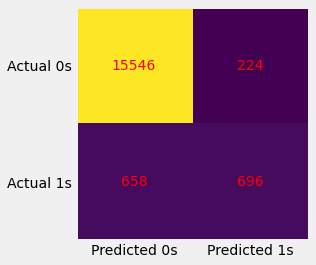

AUC	Accur	TNR	TPR	Precis	F1	MCC
0.95137	0.94849	0.98580	0.51403	0.75652	0.61214	0.59819
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     15770
           1       0.76      0.51      0.61      1354

    accuracy                           0.95     17124
   macro avg       0.86      0.75      0.79     17124
weighted avg       0.94      0.95      0.94     17124



In [115]:
# Create and train the Logistic Regression model
lr_nosplit = LogisticRegression(solver='sag', max_iter=10000, random_state=0).fit(X,y)
# Available solvers : {'lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'}

# Standardized
y_predicted = lr_nosplit.predict(X) # Predicted labels
# Evaluate the Model
tn,fp,fn,tp = confusion_matrix_plot(y, y_predicted)
metrics(X, y, lr_nosplit, tn,fp,fn,tp)
accuracy_nosplit = accuracy_score(y, y_predicted)
print(classification_report(y, y_predicted))

In [ ]:
print("Distinct values that y takes:",lr_nosplit.classes_)
# probability of y=0 (1st column) and y=1 (2nd column)
print("Prediction Probabilities (top):\n", lr_nosplit.predict_proba(X)[:3])
print("Regression Coefficients:\n")
b0_nosplit = lr_nosplit.intercept_[0]
print("Intercept b0 =", b0_nosplit)
b_nosplit = lr_nosplit.coef_
print("Coefficients b =", b_nosplit)

##### Sweeping max_iter and solver

In [ ]:
# Initialize score dataframe
if standardize:
    scores_csv = 'data/LR_std.score.solver_maxiter.csv'
else:
    scores_csv = 'data/LR.score.solver_maxiter.csv'
if os.path.exists(scores_csv):
    scores = pd.read_csv(scores_csv)
else:
    scores = pd.DataFrame(columns=['solver','max_iter','roc_auc','accuracy','tnr','tpr','precision','f1','mcc'])
display(scores.head())
display(scores.tail())

# Grid sweeping of hyperparameters, no split
for max_iter in np.arange(1,200+1):
    for solver in ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']:
        # Create and train the Logistic Regression model
        lr_nosplit = LogisticRegression(solver=solver, max_iter=max_iter, random_state=0).fit(X,y)
        roc_auc,accuracy,tnr,tpr,precision,f1,mcc = scores_all(X, y, lr_nosplit);
        scores = scores.append({'solver':solver,'max_iter':max_iter,'roc_auc':roc_auc,'accuracy':accuracy,
                          'tnr':tnr,'tpr':tpr,'precision':precision,'f1':f1,'mcc':mcc}, ignore_index=True)
        scores.to_csv(scores_csv, index=False)
scores.sort_values(['solver','max_iter'], inplace=True)
scores.to_csv(scores_csv, index=False)

,solver,max_iter,roc_auc,accuracy,tnr,tpr,precision,f1,mcc
0,lbfgs,1,0.585469,0.920930,1.000000,0.000000,NaN,0.000000,NaN
1,lbfgs,2,0.586806,0.920930,1.000000,0.000000,NaN,0.000000,NaN
2,lbfgs,3,0.585457,0.920930,1.000000,0.000000,NaN,0.000000,NaN
3,lbfgs,4,0.583859,0.920930,1.000000,0.000000,NaN,0.000000,NaN
4,lbfgs,5,0.574219,0.920754,0.999746,0.000739,0.2,0.001472,0.007659


,solver,max_iter,roc_auc,accuracy,tnr,tpr,precision,f1,mcc
495,saga,96,0.568121,0.92093,1.0,0.0,NaN,0.0,NaN
496,saga,97,0.568107,0.92093,1.0,0.0,NaN,0.0,NaN
497,saga,98,0.568096,0.92093,1.0,0.0,NaN,0.0,NaN
498,saga,99,0.568078,0.92093,1.0,0.0,NaN,0.0,NaN
499,saga,100,0.568079,0.92093,1.0,0.0,NaN,0.0,NaN


C:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Programs\anaconda3\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\Programs\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\_

C:\Programs\anaconda3\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\Programs\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-19-9ab058638767>:88: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp/(tp+fp) # TP/PP = TP/(TP+FP)
<ipython-input-19-9ab058638767>:96: RuntimeWarning: invalid value encountered in true_divide
  MCC = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
C:\Programs\anaconda3\lib\site-packages\sklearn\linear_mode

C:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-19-9ab058638767>:88: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp/(tp+fp) # TP/PP = TP/(TP+FP)
<ipython-input-19-9ab058638767>:96: RuntimeWarning: invalid value encountered in true_divide
  MCC = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
C:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-19-9ab058638767>:88: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp/(tp+fp) # TP/PP = TP/(TP+FP)
<ipython-input-19-9ab058638767>:96: RuntimeWarning: invalid value encountered in true_divide
  MCC = (tp*tn-fp*fn)/np.sqrt((tp+f

C:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-19-9ab058638767>:88: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp/(tp+fp) # TP/PP = TP/(TP+FP)
<ipython-input-19-9ab058638767>:96: RuntimeWarning: invalid value encountered in true_divide
  MCC = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
C:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i =

C:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Programs\anaconda3\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\Programs\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\_

C:\Programs\anaconda3\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\Programs\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-19-9ab058638767>:88: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp/(tp+fp) # TP/PP = TP/(TP+FP)
<ipython-input-19-9ab058638767>:96: RuntimeWarning: invalid value encountered in true_divide
  MCC = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
C:\Programs\anaconda3\lib\site-packages\sklearn\linear_mode

In [29]:
scores.tail(1)

,solver,max_iter,roc_auc,accuracy,tnr,tpr,precision,f1,mcc
999,saga,200,0.568092,0.92093,1.0,0.0,NaN,0.0,NaN


In [33]:
print("Currently optimal hyperparameters and performance: no split")
if standardize: print("Standardized:")
else: print("Unscaled:");
auc_max = -np.inf
for solver in ['newton-cg','liblinear','lbfgs','sag','saga']:
    ds = scores.loc[scores['solver']==solver]
    idx_opt = np.argmax(ds['roc_auc'])
    auc_opt = ds.iloc[idx_opt]['roc_auc']
    if auc_opt > auc_max:
        auc_max = auc_opt
        idx_max = idx_opt
        print(ds.iloc[idx_opt])

Currently optimal hyperparameters and performance:
Unscaled:
solver       newton-cg
max_iter           151
roc_auc       0.952085
accuracy      0.949253
tnr           0.986176
tpr           0.519202
precision     0.763301
f1            0.618022
mcc           0.604525
Name: 550, dtype: object


In [64]:
auc.loc[ (auc['solver']=='sag') & (auc['max_iter'] >= 10), ['solver','max_iter','roc_auc'] ] # watch a record

,solver,max_iter,roc_auc
309,sag,10,0.571689
310,sag,11,0.571140
311,sag,12,0.570468
312,sag,13,0.569991
313,sag,14,0.570009
314,sag,15,0.569532
315,sag,16,0.569353
316,sag,17,0.569115
317,sag,18,0.569149
318,sag,19,0.568990


In [60]:
print("Currently optimal hyperparameters (selected solver) and performance: no split")
if standardize: print("Standardized:")
else: print("Unscaled:");
auc_max = -np.inf
for solver in ['saga']:#['newton-cg','lbfgs','liblinear',sag','saga']
    ds = scores.loc[scores['solver']==solver]
    idx_opt = np.argmax(ds['roc_auc'])
    auc_opt = ds.iloc[idx_opt]['roc_auc']
    if auc_opt > auc_max:
        auc_max = auc_opt
        idx_max = idx_opt
        print(ds.iloc[idx_opt])

Currently optimal hyperparameters and performance:
Unscaled:
solver           saga
max_iter            1
roc_auc      0.584229
accuracy      0.92093
tnr                 1
tpr                 0
precision         NaN
f1                  0
mcc               NaN
Name: 800, dtype: object


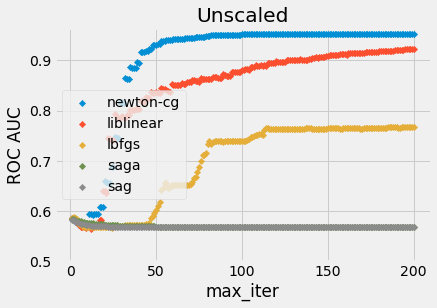

In [48]:
scores = pd.read_csv(scores_csv)
plt.xlabel('max_iter');
plt.ylabel('ROC AUC');
scores_lbfgs = scores.loc[scores['solver'] == 'lbfgs']
scores_liblinear = scores.loc[scores['solver'] == 'liblinear']
scores_newton = scores.loc[scores['solver'] == 'newton-cg']
scores_sag = scores.loc[scores['solver'] == 'sag']
scores_saga = scores.loc[scores['solver'] == 'saga']
for ds in [scores_newton, scores_liblinear, scores_lbfgs, scores_saga, scores_sag]:
    plt.scatter(ds['max_iter'], ds['roc_auc'], s=20, marker = 'D');
plt.ylabel('ROC AUC')
plt.xlabel('max_iter')
plt.legend(['newton-cg','liblinear','lbfgs','saga','sag']);
if standardize:
    plt.title("Standardized");
    plt.ylim([0.920591669910471,0.953]) # relative to dummy regressor
else:
    plt.title("Unscaled");
    plt.ylim([0.5,0.965])

Performance of optimized hyperparameters:


C:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[[TN, FP], [FN, TP]] =
 [[15770     0]
 [ 1354     0]]


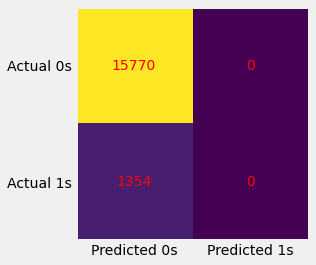

AUC	Accur	TNR	TPR	Precis	F1	MCC
0.582385	0.920930	1.000000	0.000000	nan	0.000000	nan
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     15770
           1       0.00      0.00      0.00      1354

    accuracy                           0.92     17124
   macro avg       0.46      0.50      0.48     17124
weighted avg       0.85      0.92      0.88     17124



<ipython-input-56-e257eb6e8088>:45: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp/(tp+fp) # TP/PP = TP/(TP+FP)
<ipython-input-56-e257eb6e8088>:53: RuntimeWarning: invalid value encountered in true_divide
  MCC = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
C:\Programs\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
print("Performance of optimized hyperparameters:")
# Create and train the Logistic Regression model with optimized hyperparameters
lr_nosplit = LogisticRegression(solver='sag', max_iter=1, random_state=0).fit(X,y)
y_predicted = lr_nosplit.predict(X) # Predicted labels
# Evaluate the Logistic Regression model
tn,fp,fn,tp = confusion_matrix_plot(y, y_predicted)
metrics(X, y, lr_nosplit, tn,fp,fn,tp)
accuracy_nosplit = accuracy_score(y, y_predicted)
print(classification_report(y, y_predicted))

In [ ]:
# Delete below:

[[TN, FP], [FN, TP]] =
 [[15552   218]
 [  650   704]]


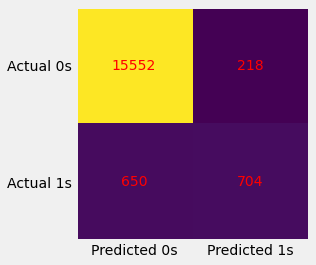

AUC	Accur	TNR	TPR	Precis	F1	MCC
0.95208	0.94931	0.98618	0.51994	0.76356	0.61863	0.60510
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     15770
           1       0.76      0.52      0.62      1354

    accuracy                           0.95     17124
   macro avg       0.86      0.75      0.80     17124
weighted avg       0.94      0.95      0.94     17124



In [101]:
#Standardized X
y_predicted = lr_nosplit.predict(X) # Predicted labels
# Evaluate the Model
tn,fp,fn,tp = confusion_matrix_plot(y, y_predicted)
metrics(X, y, lr_nosplit, tn,fp,fn,tp)
accuracy_nosplit = accuracy_score(y, y_predicted)
print(classification_report(y, y_predicted))

In [63]:
# Non-scaled, optimized hyperparameters
print("Distinct values that y takes:",lr_nosplit.classes_)
# probability of y=0 (1st column) and y=1 (2nd column)
print("Prediction Probabilities (top):\n", lr_nosplit.predict_proba(X)[:3])
print("Regression Coefficients:\n")
b0_nosplit = lr_nosplit.intercept_[0]
print("Intercept b0 =", b0_nosplit)
b_nosplit = lr_nosplit.coef_
print("Coefficients b =", b_nosplit)

Distinct values that y takes: [0 1]
Prediction Probabilities (top):
 [[0.96604492 0.03395508]
 [0.89130583 0.10869417]
 [0.89727934 0.10272066]]
Regression Coefficients:

Intercept b0 = -3.239610413957015e-07
Coefficients b = [[-3.56359367e-07  3.78933445e-08 -2.23559071e-04 -1.22959810e-07
  -6.04150339e-08 -7.97620398e-08 -6.08241578e-08 -9.07631549e-08
  -1.04577011e-07 -1.28620875e-07 -8.62021156e-08 -2.37758926e-07
  -2.28905789e-07 -2.02097919e-08 -3.44436229e-08 -4.04018381e-08
  -9.79312145e-08 -1.07997631e-07 -1.18032196e-07 -1.15619096e-07
  -2.08341946e-07 -7.07248864e-08 -7.85726243e-08 -9.28823465e-08
  -8.17811842e-08 -9.76417022e-08 -1.05770732e-07 -1.20548607e-07
  -1.01754948e-07 -2.22206094e-07 -3.63444929e-07 -5.85345670e-08
  -4.19501121e-08 -4.62123512e-08  1.00970949e-08 -6.74200623e-07
  -1.67547233e-05 -4.67664131e-07 -9.87865719e-08 -5.54065163e-08
  -6.76227487e-08 -1.79921254e-07 -1.03334113e-06 -7.75805732e-05
  -5.65792812e-07 -1.29466568e-07 -6.70172122e-0

In [102]:
# Standardized: coefficients become completely different
print("Distinct values that y takes:",lr_nosplit.classes_)
# probability of y=0 (1st column) and y=1 (2nd column)
print("Prediction Probabilities (top):\n", lr_nosplit.predict_proba(X)[:3])
print("Regression Coefficients:\n")
b0_nosplit = lr_nosplit.intercept_[0]
print("Intercept b0 =", b0_nosplit)
b_nosplit = lr_nosplit.coef_
print("Coefficients b =", b_nosplit)

Distinct values that y takes: [0 1]
Prediction Probabilities (top):
 [[0.48991452 0.51008548]
 [0.70662769 0.29337231]
 [0.77864398 0.22135602]]
Regression Coefficients:

Intercept b0 = -1.5523620666162106
Coefficients b = [[-2.59730978e+00  5.51300681e+00  1.12520660e-01 -2.65996394e-02
  -1.10782736e-01  2.53560473e-02 -9.13981750e-02  1.69947941e-01
  -7.80554340e-02 -5.37818990e-02  5.42762311e-02 -2.73415188e-01
   1.38189702e-01  2.16566091e-01 -8.08462730e-02  1.27029810e-01
  -3.29866365e-01  2.03330887e-01  3.18812799e-02 -3.13869478e-02
   3.68005475e-01  1.66313274e-01 -4.18089259e-01 -1.15735158e-01
  -6.10666292e-02  4.84565275e-02  1.31044339e-02 -2.71325920e-02
   2.76269242e-02  1.53951801e-01 -1.91804778e-01  1.02983138e+00
  -1.63782686e-01 -7.06298497e-05 -1.59711339e-01  3.85103259e-01
  -3.56405465e-01  1.53871924e-02 -8.92536263e-02  1.41918159e-01
  -4.34375767e-01 -1.98051888e-01  2.22212300e-01 -1.13743127e-01
  -3.41557897e-02 -2.24484962e-02  4.01548893e-02  

#### Unscaled input
Maximum <b>ROC AUC = 0.952085</b> is achieved using <b>'newton-cg'</b> solver at <b>max_iter = 151</b>. The convergence of AUC (to 5 decimal digits) occurs only for 'newton-cg' solver after 151 iterations. Next in accuracy is the solver 'liblinear' with a considerably lower AUC = 0.922501 after 198 iterations. This is only 0.20740% better than 0.920591669910471 in dummy regressor. However, this solver shows tendency to incease AUC after 200 iterations.

After 200 iterations, solver 'lbfgs' is close to convergence to an unacceptably low score, with maximal AUC = 0.739352 @ 81 iterations. For solver 'sag', maximal AUC = 0.582385 @ 1 iteration, and the performance slowly degrades with increasing number of iterations. The same is true for 'saga' solver, for which maximal AUC = 0.584229 @ 1 iteration. <b>Solver 'newton-cg' is recommended as the most accurate one.</b>

#### Performance of solvers, unscaled, no split

| Input    | Solver    | max_iter | ROC AUC | Accuracy | TNR     | TPR      | Precision | F1       | MCC      | TN    | FP  | FN  | TP  |
|:---------|:----------|:---------|:--------|:---------|:--------|:---------|:----------|:---------|:---------|:------|:----|:----|:----|
| Unscaled | newton-cg | 151      | .952085 | .949253  | .986176 | .519202  | .763301   | .618022  | .604525  | 15552 | 218 | 651 | 703 |
|          | liblinear | 198      | .922501 | .939150  | .994864 | .290251  | .829114   | .429978  | .468974  | 15689 | 81  | 961 | 393 |
|          | lbfgs     | 196      | .766979 | .920930  | .999746 | .00295421| .5        | .00587372| .0337236 | 15766 | 4   | 1350| 4   |
|          | saga      | 1        | .584229 | .920930  | 1       | 0        | NaN       | 0        | NaN      | 15770 | 0   | 1354| 0   |
|          | sag       | 1        | .582385 | .920930  | 1       | 0        | NaN       | 0        | NaN      | 15770 | 0   | 1354| 0   |

#### Standardized input

Maximum <b>ROC AUC = 0.952085</b> is achieved using <b>'newton-cg'</b> solver at <b>max_iter = 17</b>. But the convergence of AUC (to 5 decimal digits) occurs after max_iter = 21. Solver 'liblinear' also converges after 21 iterations to a slightly lower AUC = 0.952076. After 100 iterations, solver 'lbfgs' is close to convergence (AUC = 0.952011), but solvers 'sag' (AUC = 0.945207) and 'saga' (AUC = 0.940271) would require many more iterations to converge and thus are not recommended as time-consuming. <b>Solver 'newton-cg' is recommended as both the most accurate and quickly converging.</b>

#### 3.2.2 Training with splitting
Taking 70% for training set and 30% for test set.

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("Train samples:",y_train.shape[0])
print("Test samples:",y_test.shape[0])

Train samples: 11986
Test samples: 5138


In [125]:
# Create and train the Logistic Regression model, randoly chosen hyperparameters
#solver : {'lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'}
lr_split = LogisticRegression(solver='newton-cg', random_state=0, max_iter=1).fit(X_train, y_train); # Create and train model using training set

C:\Programs\anaconda3\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


[[TN, FP], [FN, TP]] =
 [[4730    0]
 [ 408    0]]


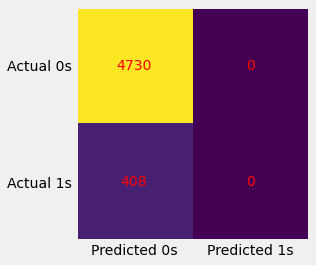

AUC	Accur	TNR	TPR	Precis	F1	MCC
0.77071	0.92059	1.00000	0.00000	nan	0.00000	nan
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4730
           1       0.00      0.00      0.00       408

    accuracy                           0.92      5138
   macro avg       0.46      0.50      0.48      5138
weighted avg       0.85      0.92      0.88      5138



<ipython-input-84-bdea89bf6fa9>:45: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp/(tp+fp) # TP/PP = TP/(TP+FP)
<ipython-input-84-bdea89bf6fa9>:53: RuntimeWarning: invalid value encountered in true_divide
  MCC = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
C:\Programs\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [126]:
# Non-scaled
y_pred_split = lr_split.predict(X_test) # predicted values
tn,fp,fn,tp = confusion_matrix_plot(y_test, y_pred_split)
metrics(X_test, y_test, lr_split, tn,fp,fn,tp)
print(classification_report(y_test, y_pred_split))

[[TN, FP], [FN, TP]] =
 [[4648   82]
 [ 219  189]]


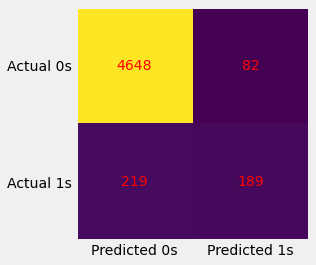

AUC	Accur	TNR	TPR	Precis	F1	MCC
0.92700	0.94142	0.98266	0.46324	0.69742	0.55670	0.53936
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4730
           1       0.70      0.46      0.56       408

    accuracy                           0.94      5138
   macro avg       0.83      0.72      0.76      5138
weighted avg       0.93      0.94      0.94      5138



In [105]:
# Standardized
y_pred_split = lr_split.predict(X_test) # predicted values
tn,fp,fn,tp = confusion_matrix_plot(y_test, y_pred_split)
metrics(X_test, y_test, lr_split, tn,fp,fn,tp)
print(classification_report(y_test, y_pred_split))

#### Sweeping max_iter and solver

In [80]:
if standardize:
    scores_csv = 'data/LR_std_test30.score.solver_maxiter.csv'
else:
    scores_csv = 'data/LR_test30.score.solver_maxiter.csv'
print(csv+', '+scores_csv)

data/df_20161022_onehot.csv, data/LR_test30.score.solver_maxiter.csv


In [ ]:
# Initialize score dataframe
if os.path.exists(scores_csv):
    scores = pd.read_csv(scores_csv)
else:
    scores = pd.DataFrame(columns=['solver','max_iter', 'roc_auc','accuracy','tnr','tpr','precision','f1','mcc'])
display(scores.head())
display(scores.tail())

# Grid sweeping of hyperparameters
for max_iter in np.arange(271,500+1):#1,500+1
    for solver in ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']:
        # Create and train the Logistic Regression model
        lr_split = LogisticRegression(solver=solver, max_iter=max_iter, random_state=0).fit(X_train, y_train);
        roc_auc,accuracy,tnr,tpr,precision,f1,mcc = scores_all(X_test, y_test, lr_split);
        scores = scores.append({'solver':solver,'max_iter':max_iter,'roc_auc':roc_auc,'accuracy':accuracy,
                          'tnr':tnr,'tpr':tpr,'precision':precision,'f1':f1,'mcc':mcc}, ignore_index=True)
    scores.to_csv(scores_csv, index=False)
scores.sort_values(['solver','max_iter'], inplace=True)
scores.to_csv(scores_csv, index=False)

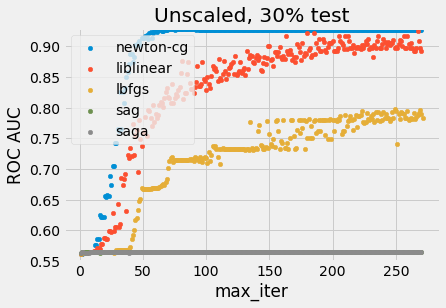

In [78]:
scores = pd.read_csv('data/LR_test30.score.solver_maxiter.csv')
plt.xlabel('max_iter');
plt.ylabel('ROC AUC');
scores_lbfgs = scores.loc[scores['solver'] == 'lbfgs']
scores_newton = scores.loc[scores['solver'] == 'newton-cg']
scores_liblinear = scores.loc[scores['solver'] == 'liblinear']
scores_sag = scores.loc[scores['solver'] == 'sag']
scores_saga = scores.loc[scores['solver'] == 'saga']
for ds in [scores_newton, scores_liblinear, scores_lbfgs, scores_sag, scores_saga]:
    plt.scatter(ds['max_iter'], ds['roc_auc'], s=20);
plt.ylim([0.55,0.93]) # relative to dummy regressor #0.920591669910471
plt.ylabel('ROC AUC')
plt.xlabel('max_iter')
plt.legend(['newton-cg','liblinear','lbfgs','sag','saga']);
plt.title("Unscaled, 30% test");

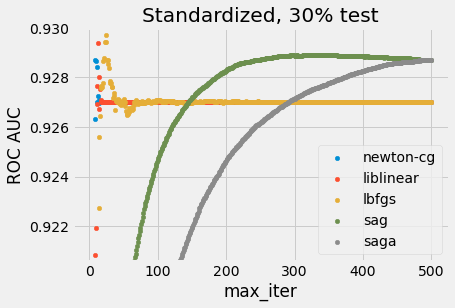

In [71]:
scores = pd.read_csv('data/LR_std_test30.score.solver_maxiter.csv')
plt.xlabel('max_iter');
plt.ylabel('ROC AUC');
scores_lbfgs = scores.loc[scores['solver'] == 'lbfgs']
scores_newton = scores.loc[scores['solver'] == 'newton-cg']
scores_liblinear = scores.loc[scores['solver'] == 'liblinear']
scores_sag = scores.loc[scores['solver'] == 'sag']
scores_saga = scores.loc[scores['solver'] == 'saga']
for ds in [scores_newton, scores_liblinear, scores_lbfgs, scores_sag, scores_saga]:
    plt.scatter(ds['max_iter'], ds['roc_auc'], s=20);
#plt.ylim([0.75,0.94])
plt.ylim([0.920591669910471,0.93]) # relative to dummy regressor #0.920591669910471
plt.ylabel('ROC AUC')
plt.xlabel('max_iter')
plt.legend(['newton-cg','liblinear','lbfgs','sag','saga']);
plt.title("Standardized, 30% test");

In [84]:
#Non-scaled
print("Distinct values that y takes:",lr_split.classes_)
# probability of y=0 (1st column) and y=1 (2nd column)
print("Prediction Probabilities (top):\n", lr_split.predict_proba(X_test)[:3])
print("Regression Coefficients:\n")
b0_split = lr_split.intercept_[0]
print("Intercept b0 =", b0_split)
b_split = lr_split.coef_
print("Coefficients b =", b_split)

Distinct values that y takes: [0 1]
Prediction Probabilities (top):
 [[0.63119671 0.36880329]
 [0.91136894 0.08863106]
 [0.98144419 0.01855581]]
Regression Coefficients:

Intercept b0 = 0.24066827598220467
Coefficients b = [[ 3.05597263e-01  2.61856828e-02 -9.63709755e-02 -3.64636457e-01
   5.80811634e-01 -1.21297472e-01 -5.37201573e-01 -8.25891255e-02
  -3.70422425e-01 -1.70149551e-01 -1.16450388e-01  1.99905228e-01
   6.62278389e-02  2.40990775e-01  4.59984639e-01  0.00000000e+00
   4.94747471e-01 -2.19444927e-02  1.92416848e-01 -6.74603032e-01
   1.62820710e-02  0.00000000e+00  3.25334065e-01 -1.80735487e-01
  -2.80942785e-01 -1.17838088e+00  5.36416023e-01  1.46169080e-01
   3.22162822e-01 -2.47719975e-01 -9.38695154e-01  1.92476781e-01
  -1.69992979e-01  3.86369479e-01 -5.23299515e-01 -6.33645718e-01
  -2.38139415e-01 -2.00020301e-01 -2.52819807e-01  2.16277886e-01
   3.38118253e-02  7.53425895e-02  4.23014070e-01 -1.11612712e-01
  -4.02511329e-01  5.14352180e-01 -1.73302080e-01  

In [106]:
#Standardized
print("Distinct values that y takes:",lr_split.classes_)
# probability of y=0 (1st column) and y=1 (2nd column)
print("Prediction Probabilities (top):\n", lr_split.predict_proba(X_test)[:3])
print("Regression Coefficients:\n")
b0_split = lr_split.intercept_[0]
print("Intercept b0 =", b0_split)
b_split = lr_split.coef_
print("Coefficients b =", b_split)

Distinct values that y takes: [0 1]
Prediction Probabilities (top):
 [[0.99400353 0.00599647]
 [0.99394189 0.00605811]
 [0.90694552 0.09305448]]
Regression Coefficients:

Intercept b0 = -1.3318550972549834
Coefficients b = [[-2.31541065e+00  5.52533163e+00  2.21309246e-01 -9.43494374e-02
  -1.23396526e-01 -4.19843650e-03 -7.56360829e-02  1.53651313e-01
  -7.86503830e-02 -5.29727903e-02  5.23376371e-02 -3.71242088e-01
   1.16509221e-01  3.21262204e-01 -6.71644896e-02  9.73359594e-02
  -2.72422721e-01  1.74451608e-01  2.22704269e-03 -2.86219596e-03
   3.39040892e-01  2.52578515e-01 -4.11969303e-01 -1.80285257e-01
  -4.62848843e-04  1.38283402e-02 -1.40006446e-02 -2.39931876e-02
   2.33580343e-02  1.48183732e-01 -2.33583109e-01  9.66676633e-01
  -7.51645314e-02 -4.08028895e-02 -2.52061792e-02  5.18899353e-01
  -1.12476623e-01  1.86066230e-01  8.18088328e-02  6.04704872e-02
  -2.96469969e-01 -3.18511847e-01  2.26345791e-01 -2.33372957e-01
   2.59540062e-01 -4.98877963e-01  1.84542038e-01 -

In [82]:
print("Currently optimal hyperparameters and performance: 30% test")
if standardize: print("Standardized:")
else: print("Unscaled:");
auc_max = -np.inf
for solver in ['newton-cg','liblinear','lbfgs','sag','saga']:
    ds = scores.loc[scores['solver']==solver]
    idx_opt = np.argmax(ds['roc_auc'])
    auc_opt = ds.iloc[idx_opt]['roc_auc']
    if auc_opt > auc_max:
        auc_max = auc_opt
        idx_max = idx_opt
        print(ds.iloc[idx_opt])

Currently optimal hyperparameters and performance:
Unscaled:
solver       newton-cg
max_iter            77
roc_auc       0.928263
accuracy      0.941806
tnr           0.983721
tpr           0.455882
precision     0.707224
f1            0.554396
mcc           0.539332
Name: 476, dtype: object


In [92]:
print("Currently optimal hyperparameters (selected solver) and performance: 30% test")
if standardize: print("Standardized:")
else: print("Unscaled:");
auc_max = -np.inf
for solver in ['saga']:#['newton-cg','liblinear','lbfgs','sag','saga']
    ds = scores.loc[scores['solver']==solver]
    idx_opt = np.argmax(ds['roc_auc'])
    auc_opt = ds.iloc[idx_opt]['roc_auc']
    if auc_opt > auc_max:
        auc_max = auc_opt
        idx_max = idx_opt
        print(ds.iloc[idx_opt])

Currently optimal hyperparameters (selected solver) and performance: 30% test
Unscaled:
solver           saga
max_iter           13
roc_auc      0.565467
accuracy     0.920592
tnr                 1
tpr                 0
precision         NaN
f1                  0
mcc               NaN
Name: 812, dtype: object


#### Performance of solvers: unscaled, 30% test

| Input    | Solver    | max_iter | ROC AUC | Accuracy | TNR     | TPR      | Precision | F1       | MCC      | TN    | FP | FN  | TP  |
|:---------|:----------|:---------|:--------|:---------|:--------|:---------|:----------|:---------|:---------|:------|:---|:----|:----|
| Unscaled | newton-cg |  77      | .928263 | .941806  | .983721 | .455882  | .707224   | .554396  | .539332  |  4655 | 75 |  223| 185 |
|          | liblinear | 267      | .924624 | .942585  | .987949 | .416667  | .748899   | .535433  | .532360  |  4671 | 59 |  241| 167 |
|          | lbfgs     | 249      | .797873 | .920008  | .999154 | .00245098| .2        | .00484262| .0139203 |  4725 |  5 |  405|   3 |
|          | sag       |   6      | .565330 | .920592  | 1       | 0        | NaN       | 0        | NaN      |  4730 |  0 |  408|   0 |
|          | saga      |  13      | .565467 | .920592  | 1       | 0        | NaN       | 0        | NaN      |  4730 |  0 |  408|   0 |

C:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[[TN, FP], [FN, TP]] =
 [[4730    0]
 [ 408    0]]


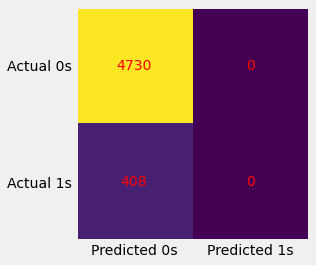

AUC	Accur	TNR	TPR	Precis	F1	MCC
0.565467	0.920592	1.000000	0.000000	nan	0.000000	nan
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4730
           1       0.00      0.00      0.00       408

    accuracy                           0.92      5138
   macro avg       0.46      0.50      0.48      5138
weighted avg       0.85      0.92      0.88      5138



<ipython-input-56-e257eb6e8088>:45: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp/(tp+fp) # TP/PP = TP/(TP+FP)
<ipython-input-56-e257eb6e8088>:53: RuntimeWarning: invalid value encountered in true_divide
  MCC = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
C:\Programs\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
# Specify solver, max_iter. See performance.
# Create and train the Logistic Regression model, randoly chosen hyperparameters
#solver : {'lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'}
lr_split = LogisticRegression(solver='saga', max_iter=13, random_state=0).fit(X_train, y_train); # Create and train model using training set

y_pred_split = lr_split.predict(X_test) # predicted values
tn,fp,fn,tp = confusion_matrix_plot(y_test, y_pred_split)
metrics(X_test, y_test, lr_split, tn,fp,fn,tp)
print(classification_report(y_test, y_pred_split))

#### Comparison to no split
Quality of the model does not depend on the solver in both cases of no split and 30% test set. Compared to no splitting, many of the model coefficients differ by more than 20%,

In [19]:
#Non-scaled
print("Intercept relative error:",b0_split/b0_nosplit-1)
print("Coefficient relative error:",b_split/b_nosplit-1)

Intercept relative error: -0.2929273589595419
Coefficient relative error: [[ 4.08480097e-01 -1.23628197e+00  1.32309358e-01  3.36089687e+00
   2.47904048e-01 -3.14187712e+00  2.57966856e-01 -1.52828391e+00
  -2.34199904e+00  2.85726120e+01 -1.84323462e-01  4.70841974e-01
  -1.35478847e+00  1.13812737e+00  7.71369682e-02 -1.00000000e+00
  -4.91146183e+00 -1.22635573e+00  3.06161132e+00 -2.39790484e-01
  -9.61215185e-01 -1.00000000e+00 -9.53429778e-02 -3.68892198e-01
   6.34838100e-02 -6.01260589e-02  2.50616074e-01 -2.40078290e+00
   4.50907388e-01 -4.33618492e-01  8.36982833e-03 -1.73367006e+00
  -3.39023158e+00 -1.49291841e-01 -4.02628541e-01 -3.83975084e-01
   1.24136943e+01 -5.04031275e-01 -1.95871801e+00  6.51723747e-02
  -1.12767975e+00 -2.03087560e+00  3.47083237e-01 -1.26547255e+00
   7.61715623e-02 -5.58124257e-01 -6.72889788e-01 -2.40922487e-01
   9.49192313e-01  5.42030359e+00  2.07507349e+00  5.78717810e-02
  -1.10560042e-02 -1.14800964e-01 -1.84028269e-01  1.06753799e-01
  

<ipython-input-19-69d93c4e9c82>:2: RuntimeWarning: invalid value encountered in true_divide
  print("Coefficient relative error:",b_split/b_nosplit-1)


In [107]:
#Standardized
print("Intercept relative error:",b0_split/b0_nosplit-1)
print("Coefficient relative error:",b_split/b_nosplit-1)

Intercept relative error: -0.14204609485329744
Coefficient relative error: [[-1.08535043e-01  2.23558992e-03  9.66832096e-01  2.54701942e+00
   1.13860607e-01 -1.16557930e+00 -1.72455217e-01 -9.58918852e-02
   7.62213428e-03 -1.50442565e-02 -3.57171828e-02  3.57796146e-01
  -1.56889271e-01  4.83437240e-01 -1.69232086e-01 -2.33754980e-01
  -1.74142169e-01 -1.42030950e-01 -9.30145756e-01 -9.08809356e-01
  -7.87069339e-02  5.18691252e-01 -1.46379179e-02  5.57739762e-01
  -9.92420593e-01 -7.14623789e-01 -2.06838989e+00 -1.15706029e-01
  -1.54519187e-01 -3.74667204e-02  2.17816943e-01 -6.13253303e-02
  -5.41071567e-01  5.76700359e+02 -8.42176646e-01  3.47429140e-01
  -6.84413864e-01  1.10922794e+01 -1.91658834e+00 -5.73905922e-01
  -3.17480414e-01  6.08224235e-01  1.86015382e-02  1.05175435e+00
  -8.59871355e+00  2.12232242e+01  3.59575511e+00 -1.60116536e+00
   5.73959191e-02 -1.63222556e-01 -3.19847011e-01 -1.01916261e+00
  -8.95569227e-02 -3.60209617e-01  5.82815382e-02  5.67484721e-01
 

#### Observations

The optimal solver is 'newton-cg' (both with and without splitting). AUC for the 30% test set is 0.92660, which is 2.7% lower than 0.95208 when training the model on the entire set of records. Accuracy decreases by 0.8%, TNR - by 0.4%, TPR - by 10.3%, precision - by 9.2%, F1 score - by 9.8%, and MCC - by 10.8%.

In [27]:
roc_auc_nosplit = 0.95208
roc_auc_split = 0.92660
print("Relative difference in ROC AUC =", roc_auc_split/roc_auc_nosplit-1)

Relative difference in ROC AUC = -0.02676245693639201


The change in the proportion of positive values 1 of the label `is_churn` in the test dataset compared to the full dataset is only 0.43%,

In [31]:
print("Proportion of `is_churn==1` in the full set:", np.sum(y)/len(y))

Proportion of `is_churn==1` in the full set: 0.07907031067507592


In [32]:
print("Proportion of `is_churn==1` in the test set:", np.sum(y_test)/len(y_test))

Proportion of `is_churn==1` in the test set: 0.079408330089529


so this is not the reason for the considerable reduction in the model quality.

#### 3.2.3 Optimization of the regularization hyperparameter C
Let's try to adjust the regularization strength C.

In [120]:
def opt_C_rocauc(Cmin,Cmax,Cstep, solver='lbfgs'):#Cmax+Cstep
    #solver : {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}
    global rocauc
    '''Optimize regularization parameter C by maximizing accuracy in Logistic Regression for Train-Test split.'''
    rocauc = pd.DataFrame({'C':[],'ROC AUC':[]})
    rocauc_opt = 0
    for C in np.arange(Cmin, Cmax, Cstep):
        lr_C = LogisticRegression(C=C, solver=solver, random_state=0, max_iter=10000).fit(X_train, y_train)
        #pred = lr_C.predict(X_test) # predicted values
        metric = roc_auc_score(y_test, lr_C.predict_proba(X_test)[:, 1]) # ROC AUC score
        rocauc = rocauc.append({'C':C,'ROC AUC':metric}, ignore_index=True)
        rocauc.to_csv("data/LR_std_C."+solver+".1.csv", index=False)
        if rocauc_opt < metric:
            rocauc_opt = metric
            C_opt = C
    print('Optimal C =',C_opt)
    print('Highest ROC AUC =',rocauc_opt)
    fig, axs = plt.subplots(figsize = (16,8))
    plt.scatter(rocauc['C'],rocauc['ROC AUC']);
    plt.xlabel('C');
    plt.ylabel('ROC AUC');

def opt_C_accuracy(Cmin,Cmax,Cstep, solver='lbfgs'):
    '''Optimize regularization parameter C by maximizing accuracy in Logistic Regression for Train-Test split.'''
    global accuracy
    accuracy = pd.DataFrame({'C':[],'Accuracy':[]})
    acc_opt = 0
    for C in np.arange(Cmin, Cmax+Cstep, Cstep):
        lr_C = LogisticRegression(C=C, solver=solver, random_state=0, max_iter=10000).fit(X_train, y_train)
        pred = lr_C.predict(X_test) # predicted values
        acc = lr_C.score(X_test, y_test) # proportion of correct predictions
        accuracy = accuracy.append({'C':C,'Accuracy':acc}, ignore_index=True)
        if acc_opt < acc:
            acc_opt = acc
            C_opt = C
    print('Optimal C =',C_opt)
    print('Highest accuracy =',acc_opt)
    fig, axs = plt.subplots(figsize = (16,8))
    plt.scatter(accuracy['C'],accuracy['Accuracy']);
    plt.xlabel('C');
    plt.ylabel('Accuracy');

Optimal C = 5.0
Highest ROC AUC = 0.9252443207727067


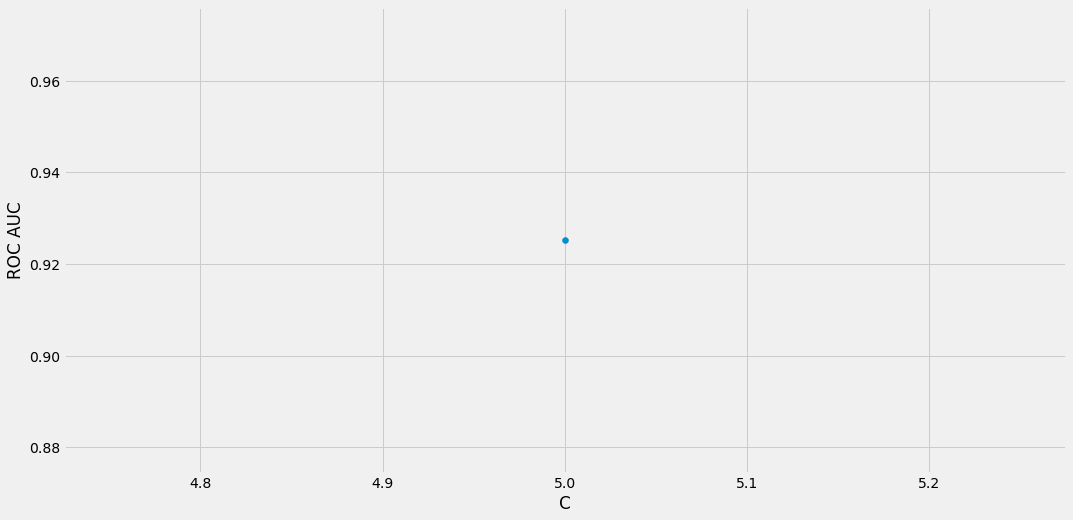

In [129]:
opt_C_rocauc(5, 5.01, 0.1, solver = 'lbfgs')
#solver : {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}

In [84]:
del Rocauc
# Save scores
try: Rocauc
except NameError: # if variable does not exist, initialize it
    Rocauc=rocauc
else: # if variable exists, append to it
    Rocauc=pd.concat([Rocauc, rocauc], axis=0)
Rocauc

,C,ROC AUC
0,0.1,0.564903
1,0.2,0.564903
2,0.3,0.564903
3,0.4,0.564903
4,0.5,0.564903
5,0.6,0.564903
6,0.7,0.564903
7,0.8,0.564903
8,0.9,0.564903
9,1.0,0.564903


In [118]:
rocauc.to_csv("data/LR_std_C.lbfgs.1.csv", index=False)

Optimal C = 0.22
Max AUC = 0.928351314098578


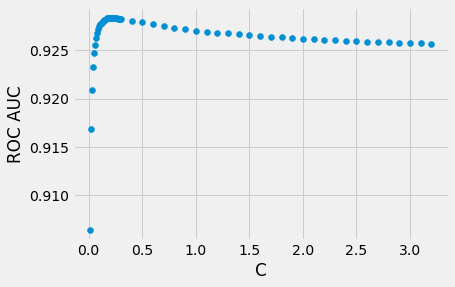

In [127]:
Rocauc = pd.read_csv("data/LR_std_C.lbfgs.csv")

idx_opt = np.argmax(Rocauc['ROC AUC'])
C_opt = Rocauc['C'].iloc[idx_opt]
auc_max = Rocauc['ROC AUC'].iloc[idx_opt]
print("Optimal C =", C_opt)
print("Max AUC =", auc_max)

plt.xlabel('C');
plt.ylabel('ROC AUC');
plt.scatter(Rocauc['C'], Rocauc['ROC AUC']);

Optimized C in Logistic Regression with 30% test split:
[[TN, FP], [FN, TP]] =
 [[4730    0]
 [ 408    0]]


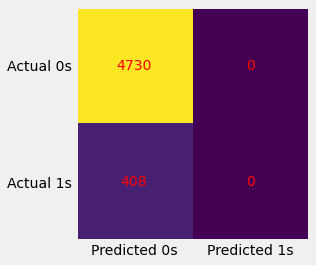

AUC	Accur	TNR	TPR	Precis	F1	MCC
0.56490	0.92059	1.00000	0.00000	nan	0.00000	nan
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4730
           1       0.00      0.00      0.00       408

    accuracy                           0.92      5138
   macro avg       0.46      0.50      0.48      5138
weighted avg       0.85      0.92      0.88      5138



<ipython-input-11-bdea89bf6fa9>:45: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp/(tp+fp) # TP/PP = TP/(TP+FP)
<ipython-input-11-bdea89bf6fa9>:53: RuntimeWarning: invalid value encountered in true_divide
  MCC = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
C:\Programs\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [86]:
#Non-scaled
print('Optimized C in Logistic Regression with 30% test split:')
C_opt = 1
#solver : {'lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'}
lr_C = LogisticRegression(C=C_opt, solver='sag', random_state=0, max_iter=10000).fit(X_train, y_train) # Create and train model using training set
pred_C = lr_C.predict(X_test) # predicted values
tn,fp,fn,tp = confusion_matrix_plot(y_test, pred_C)
metrics(X_test, y_test, lr_C, tn,fp,fn,tp)
print(classification_report(y_test, pred_C))

Optimized C in Logistic Regression with 30% test split:
[[TN, FP], [FN, TP]] =
 [[4665   65]
 [ 228  180]]


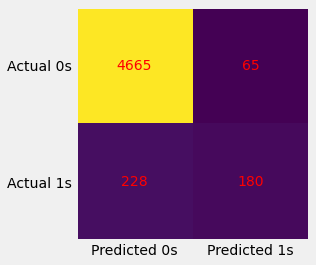

AUC	Accur	TNR	TPR	Precis	F1	MCC
0.92835	0.94297	0.98626	0.44118	0.73469	0.55130	0.54232
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      4730
           1       0.73      0.44      0.55       408

    accuracy                           0.94      5138
   macro avg       0.84      0.71      0.76      5138
weighted avg       0.94      0.94      0.94      5138



In [130]:
#Standardized
print('Optimized C in Logistic Regression with 30% test split:')
C_opt = 0.22
#solver : {'lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'}
lr_C = LogisticRegression(C=C_opt, solver='lbfgs', random_state=0, max_iter=10000).fit(X_train, y_train) # Create and train model using training set
pred_C = lr_C.predict(X_test) # predicted values
tn,fp,fn,tp = confusion_matrix_plot(y_test, pred_C)
metrics(X_test, y_test, lr_C, tn,fp,fn,tp)
print(classification_report(y_test, pred_C))

Optimization of the regularization parameter 'C' did not lead to an improvement in accuracy, since the accuracy and other performance metrics stay same for $C \in [0.392, 1.756]$. A way to increase recall is to adjust the threshold probability, which will be done below when considering ROC and Precision-Recall curves.

#### Cross-Validation
A more reliable way of validating the model and optimizing its parameters is by cross-validation.

https://scikit-learn.org/stable/modules/cross_validation.html

In [33]:
#Non-scaled
from sklearn.model_selection import cross_val_score
print("Example of cross-validation:")
lr_cv = LogisticRegression(random_state=0, max_iter=10000) #solver='liblinear'
scores = cross_val_score(lr_cv, X, y, cv=10) #X_train, y_train
print('Cross-Validation Accuracy Scores', scores)
scores.min(), scores.mean(), scores.max()

Example of cross-validation:


C:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Cross-Validation Accuracy Scores [0.92877992 0.92994746 0.931115   0.92586106 0.92523364 0.93107477
 0.92231308 0.94100467 0.96495327 0.9760514 ]


C:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.9223130841121495, 0.9376334285371349, 0.9760514018691588)

In [131]:
#Standardized
from sklearn.model_selection import cross_val_score
print("Example of cross-validation:")
lr_cv = LogisticRegression(random_state=0, max_iter=10000) #solver='liblinear'
scores = cross_val_score(lr_cv, X, y, cv=10) #X_train, y_train
print('Cross-Validation Accuracy Scores', scores)
scores.min(), scores.mean(), scores.max()

Example of cross-validation:
Cross-Validation Accuracy Scores [0.92469352 0.931115   0.9270286  0.92352598 0.92114486 0.92172897
 0.90595794 0.92757009 0.95502336 0.97254673]


(0.9059579439252337, 0.9310335068279404, 0.9725467289719626)

In [132]:
def optCV_C_rocauc(Cmin,Cmax,Cstep, solver='lbfgs'):
    #solver : {'lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'}
    '''Optimize regularization parameter C by maximizing accuracy in Logistic Regression with 10-fold Cross-Validation.'''
    global rocauc
    rocauc = pd.DataFrame({'C':[],'ROC AUC':[]})
    rocauc_opt = 0
    for C in np.arange(Cmin, Cmax+Cstep, Cstep):
        lr_cv = LogisticRegression(C=C, solver=solver, random_state=0, max_iter=10000).fit(X_train, y_train)
        metric = np.mean(cross_val_score(lr_cv, X, y, scoring='roc_auc', cv=10)) # accuracies of cv cross-validations
        rocauc = rocauc.append({'C':C,'ROC AUC':metric}, ignore_index=True)
        Rocauc.to_csv('data/LR_std_Ccv.'+solver+'.1.csv') #save
        if rocauc_opt < metric:
            rocauc_opt = metric
            C_opt = C
    print('Optimal C =',C_opt)
    print('Highest ROC AUC =',rocauc_opt)
    fig, axs = plt.subplots(figsize = (16,8))
    plt.scatter(rocauc['C'],rocauc['ROC AUC']);
    plt.xlabel('C');
    plt.ylabel('ROC AUC');
    #display(rocauc)

def optCV_C_accuracy(Cmin,Cmax,Cstep, solver='lbfgs'):
    #solver : {'lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'}
    '''Optimize regularization parameter C in Logistic Regression with 10-fold Cross-Validation'''
    global accuracy
    accuracy = pd.DataFrame({'C':[],'Accuracy':[]})
    acc_opt = 0
    for C in np.arange(Cmin, Cmax+Cstep, Cstep):
        log_reg_cv = LogisticRegression(C=C, solver=solver, max_iter=10000, random_state=0) #liblinear
        scores = cross_val_score(log_reg_cv, X, y, cv=10) # accuracies of cv cross-validations
        acc = scores.mean()
        accuracy = accuracy.append({'C':C,'Accuracy':acc}, ignore_index=True)
        if acc_opt < acc:
            acc_opt = acc
            C_opt = C
    print('Optimal C =',C_opt)
    print('Highest accuracy =',acc_opt)
    fig, axs = plt.subplots(figsize = (16,8))
    plt.scatter(accuracy['C'],accuracy['Accuracy']);
    plt.xlabel('C');
    plt.ylabel('Accuracy');
    #display(accuracy)

In [ ]:
#Rocauc = pd.read_csv('data/LR_Ccv_allonehot.csv')

In [135]:
solver = 'lbfgs'

Optimal C = 0.08
Highest ROC AUC = 0.916641820118451


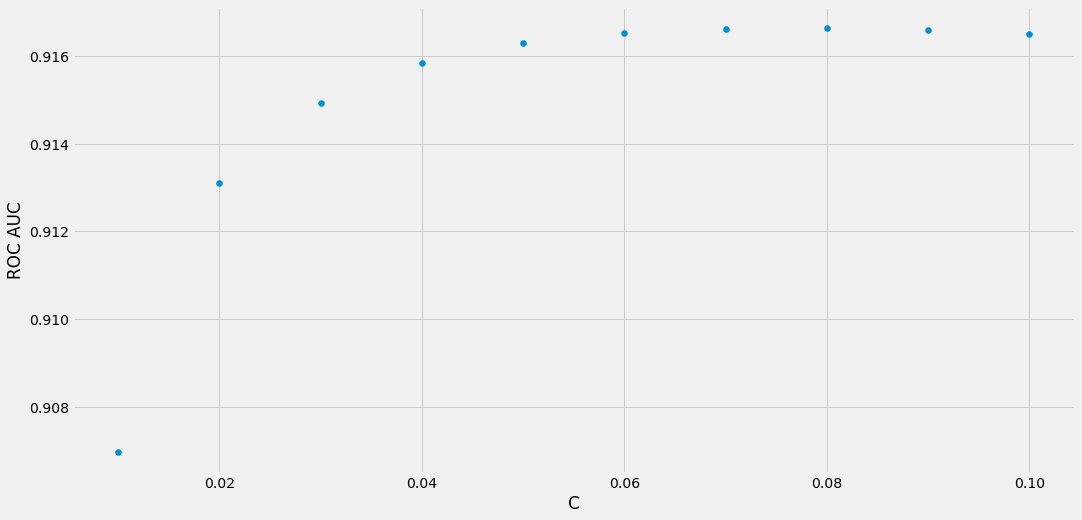

In [138]:
optCV_C_rocauc(0.01, 0.1, 0.01, solver = 'lbfgs')

In [ ]:
#00:56-

In [36]:
del Rocauc
#Rocauc = pd.read_csv('data/LR_Ccv.csv')
try: Rocauc.tail(1) # Test if a variable is defined
except NameError:
    Rocauc = rocauc
else:
    Rocauc=pd.concat([Rocauc, rocauc], ignore_index=True)
    Rocauc.sort_values('C', inplace = True)
Rocauc

,C,ROC AUC
0,5.0,0.906428
1,6.0,0.905921
2,7.0,0.905536
3,8.0,0.905197
4,9.0,0.904928


Optimal C = 0.1
Highest ROC AUC = 0.9275


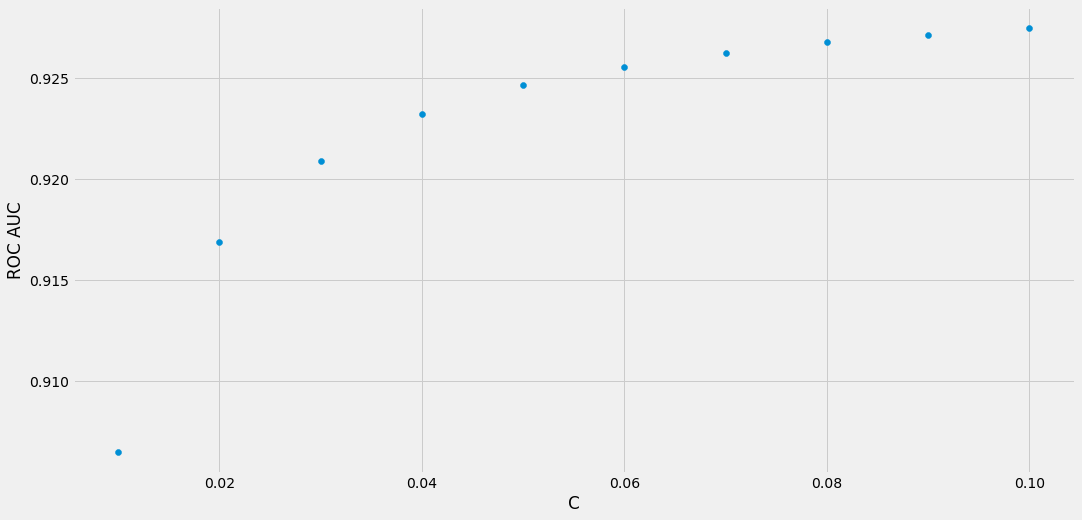

In [137]:
Rocauc = pd.read_csv('data/LR_std_Ccv.'+solver+'.csv') #read
idx_opt = np.argmax(Rocauc['ROC AUC'])
C_opt = round(Rocauc['C'].iloc[idx_opt],4)
print('Optimal C =', C_opt)
rocauc_opt = round(Rocauc['ROC AUC'].iloc[idx_opt],5)
print('Highest ROC AUC =',rocauc_opt)

fig, axs = plt.subplots(figsize = (16,8))
plt.scatter(Rocauc['C'],Rocauc['ROC AUC']);
plt.xlabel('C');
plt.ylabel('ROC AUC');

Optimal C = 3
Highest ROC AUC = 0.916164968331558


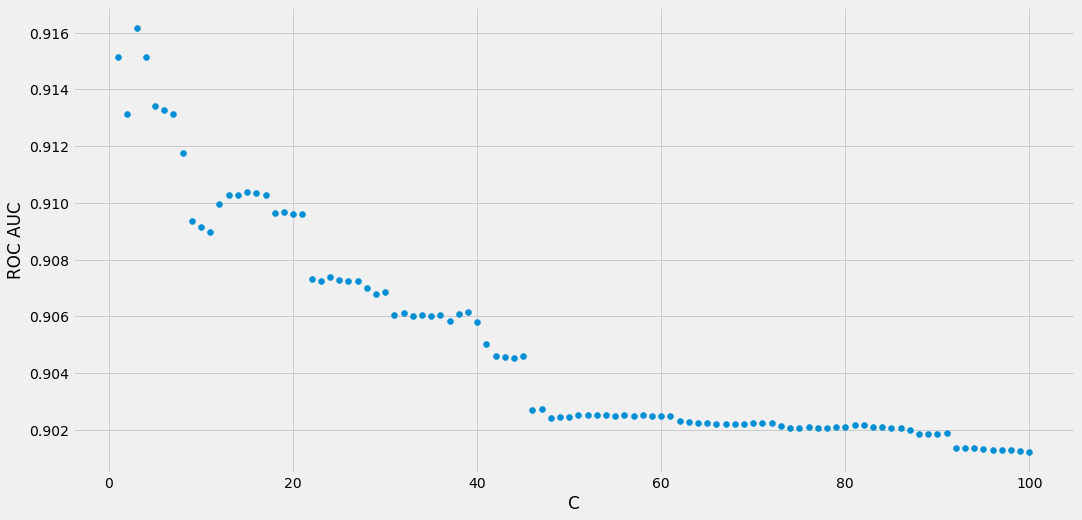

In [200]:
optCV_C_rocauc(1, 100, 1, solver='newton-cg')

Optimal C = 2.8000000000000003
Highest ROC AUC = 0.9168929383178636


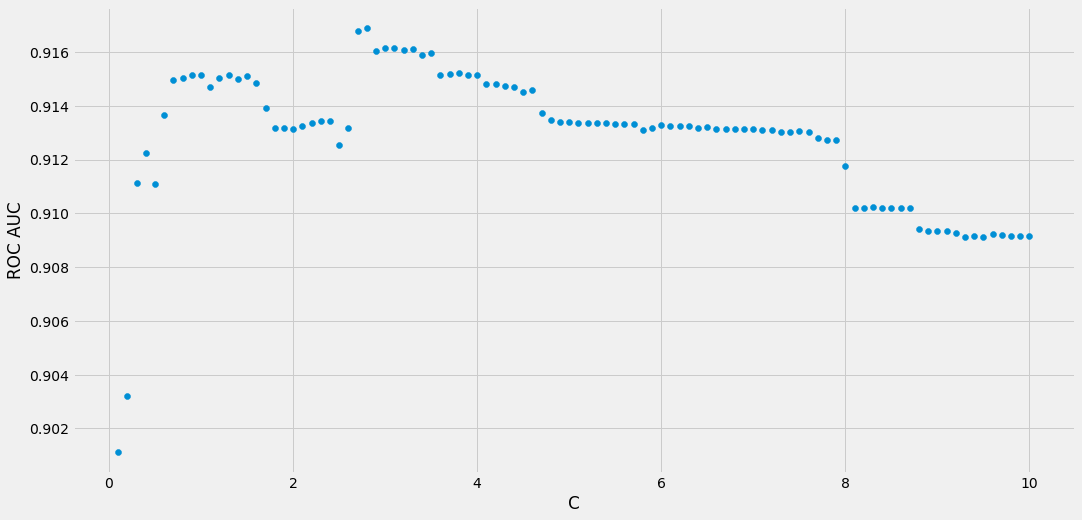

In [203]:
optCV_C_rocauc(0.1, 10, 0.1, solver='newton-cg')

Optimal C = 2.8099999999999827
Highest ROC AUC = 0.9169130996081861


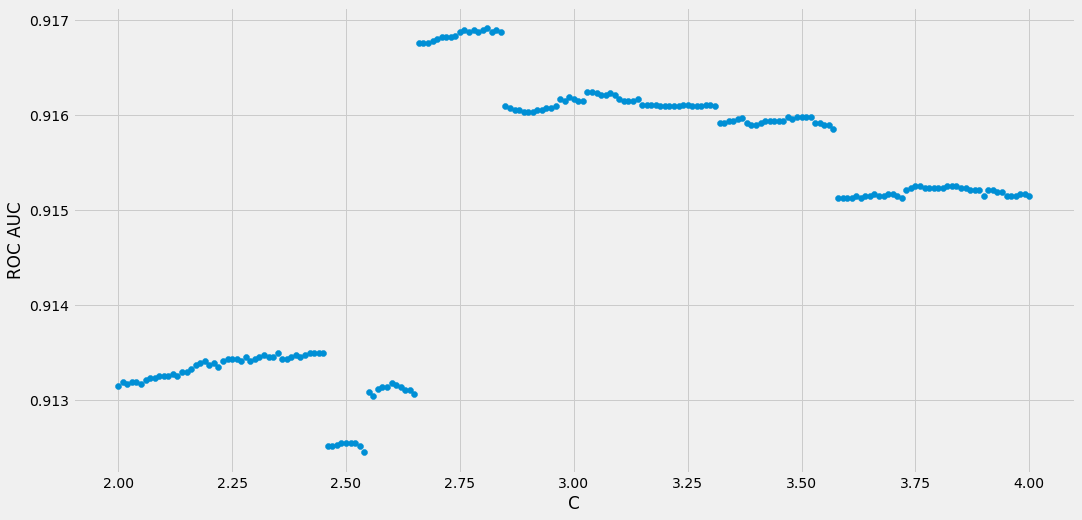

In [210]:
optCV_C_rocauc(2, 4, 0.01, solver='newton-cg')

Optimal C = 52.0


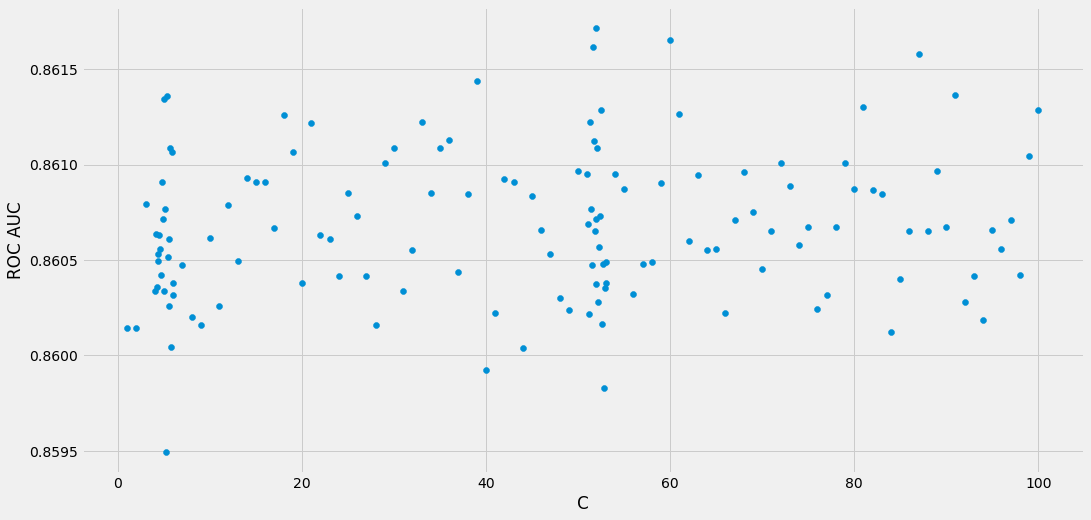

In [26]:
print('Optimal C =',C_opt)
#print('Highest ROC AUC =',rocauc_opt)
fig, axs = plt.subplots(figsize = (16,8))
plt.scatter(Rocauc['C'],Rocauc['ROC AUC']);
plt.xlabel('C');
plt.ylabel('ROC AUC');

Optimal C = 0.2
Highest accuracy = 0.9162767233856893


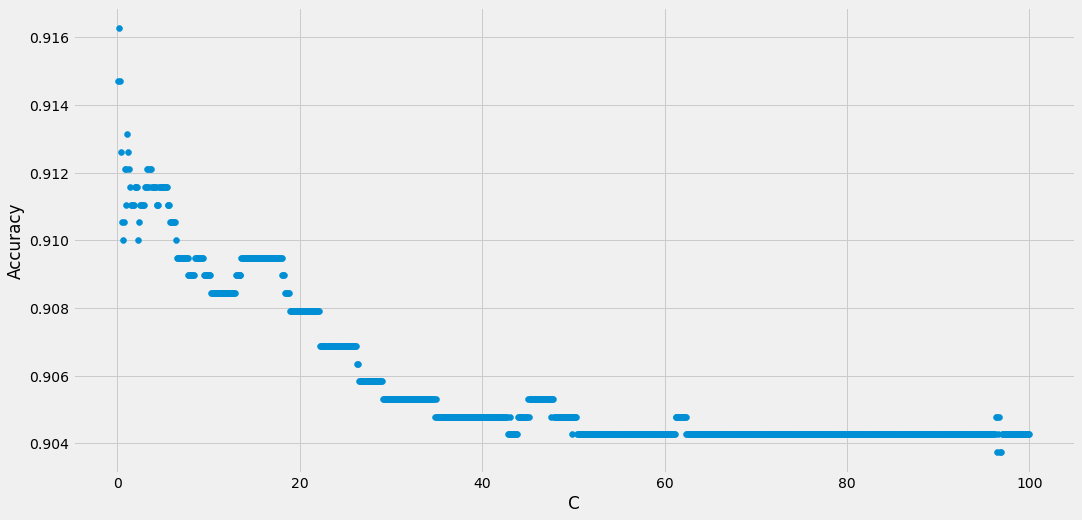

In [93]:
optCV_C_accuracy(0.1, 100, 0.1)

Optimal C = 0.22
Highest accuracy = 0.9162794502617801


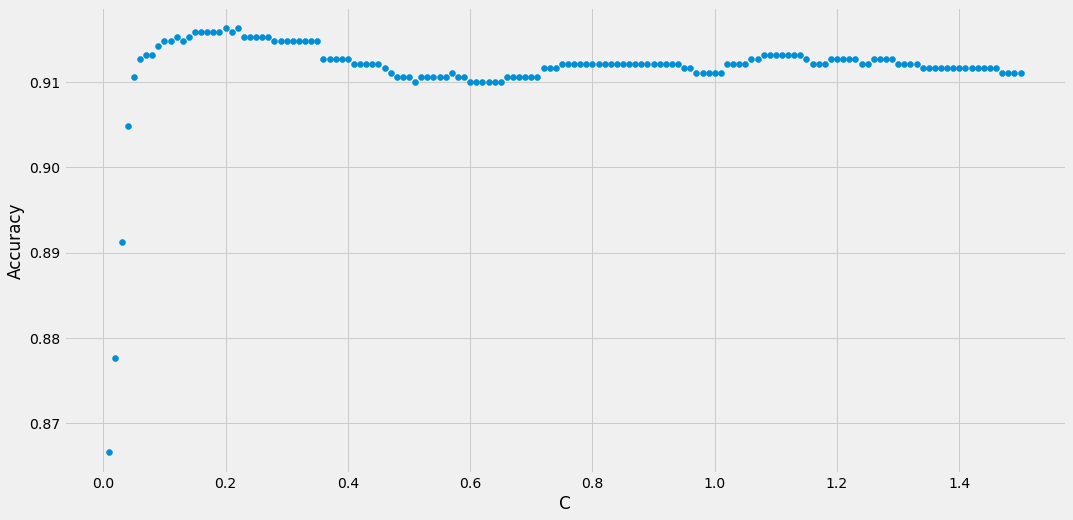

In [94]:
optCV_C_accuracy(0.01, 1.5, 0.01)

Optimized C in Logistic Regression with 10-fold Cross-Validation:
[[TN, FP], [FN, TP]] =
 [[1561   33]
 [  97  221]]


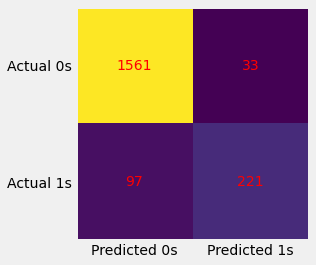

TNR = 0.9793 Specificity, proportion of the negative class 0 got correctly classified.
FNR = 0.305 or Type II Error: Proportion of the positive class 1 got incorrectly classified.
roc_auc_score = 0.9558
Accuracy = 0.932: (TN+TP)/(TN+TP+FN+FP): Percentage of total items classified correctly
FPR = 0.0207 Specificity, or Type I Error: proportion of the negative class 0 got incorrectly classified.
TPR = 0.695: TP/(TP+FN): Recall, sensitivity, proportion of the positive class 1 got correctly classified.
Precision = 0.8701: TP/PP = TP/(TP+FP)
F1 score = 0.7727: harmonic mean of precision and recall.
MCC = 0.7397 Matthews correlation coefficient: accounts for all 4 confusion matrix categories.
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1594
           1       0.87      0.69      0.77       318

    accuracy                           0.93      1912
   macro avg       0.91      0.84      0.87      1912
weighted avg       0.93      0.9

In [27]:
# Scores for the full data set
print('Optimized C in Logistic Regression with 10-fold Cross-Validation:')
C_opt = 52.0
lr_cv = LogisticRegression(solver='lbfgs', C=C_opt, random_state=0, max_iter=8000).fit(X_train, y_train) # Create and train model using training set
pred_Ccv = lr_cv.predict(X) # predicted values
tn,fp,fn,tp = confusion_matrix_plot(y, pred_Ccv)
metrics(X, y, lr_cv, tn,fp,fn,tp)
print(classification_report(y, pred_Ccv))

In [28]:
# CV average scores
#from sklearn.metrics import SCORERS
#sorted(SCORERS.keys()) # scoring options
roc_auc = np.mean(cross_val_score(lr_cv, X, y, scoring='roc_auc', cv=10)) # accuracies of cv cross-validations
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
accuracy = np.mean(cross_val_score(lr_cv, X, y, scoring='accuracy', cv=10))
recall = np.mean(cross_val_score(lr_cv, X, y, scoring='recall', cv=10)) # TPR
precision = np.mean(cross_val_score(lr_cv, X, y, scoring='precision', cv=10))
f1 = np.mean(cross_val_score(lr_cv, X, y, scoring='f1', cv=10))
print("AUC\tAccur\tTPR\tPrecis\tF1")
print("%.5f\t%.5f\t%.5f\t%.5f\t%.5f" % (roc_auc, accuracy, recall, precision, f1))

roc_auc	accuracy	recall	precision	f1
0.9025 | 0.9043 | 0.6320 | 0.7647 | 0.6831


### Quality metrics
F1 score is very sensitive to what is called a positive and a negative class. Since we want to correctly classify the positive class is_churn == 1, a higher TPR and a lower FNR is desirable. We use ROC-AUC score as a main quality metric.

In [45]:
df.columns

Index(['city', 'bd', 'registered_via', 'payment_method_id1',
       'payment_plan_days1', 'actual_amount_paid1', 'is_auto_renew1',
       'is_cancel1', 'discount1', 'is_churn', 'gender_female', 'gender_male',
       'gender_unknown'],
      dtype='object')

| Transactions | Cut-off date | Features | Mode | solver | C | ROC AUC | Accuracy | FPR | TPR | Precision | F1 | MCC |
|---:|:-------------|:-----------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|
| 1 | 2016-10-22 | gender_onehot | No split | - | 1 | 0.8624 | 0.8269 | 0.0270 | 0.0943 | 0.4110 | 0.1535 | 0.1309|
| 1 | 2016-10-22 | No split | - | 1 | 0.9570 | 0.9247 | 0.0182 | 0.6384 | 0.875 | 0.7382 | 0.7072 |
| 1 | 2016-10-22 | 30% Test | - | 1 | 0.9212 | 0.9094 | 0.0251 | 0.5833 | 0.8235 | 0.6829 | 0.6447 |
| 1 | 2016-10-22 | 30% Test, opt. C | - | 1.55 | 0.9281 | 0.9094 | 0.0251 | 0.5833 | 0.8235 | 0.6829 | 0.6447 |
|---|-------------|---------|------|--------|--------|--------|--------|--------|--------|
| 1 | 2016-10-22 | CV 10 | lbfgs | 2.81 | 0.9540 | 0.9283 | 0.0169 | 0.6541 | 0.8851 | 0.7523 | 0.7226 |
| 1 | 2016-10-22 | CV 10* | lbfgs | 2.81 | 0.9169 | 0.9111 | - | 0.6194 | 0.8106 | 0.6931 | - |
| 1 | 2016-10-22 | CV 10 | newton-cg | ? | ? | ? | 0.0251 | 0.5833 | 0.8235 | 0.6829 | 0.6447 |
| 1 | 2016-10-22 | 30% Test | liblinear | 2.76 | ? | 0.9094 | 0.0251 | 0.5833 | 0.8235 | 0.6829 | 0.6447 |
| 1 | 2016-10-22 | 30% Test | sag | 1 | ? | 0.9094 | 0.0251 | 0.5833 | 0.8235 | 0.6829 | 0.6447 |
| 1 | 2016-10-22 | 30% Test | saga | 1 | ? | 0.9094 | 0.0251 | 0.5833 | 0.8235 | 0.6829 | 0.6447 |
* average over 10 CV folds.

### ROC - AUC, Optimization of classification threshold
Area Under the Curve (AUC) of Receiver Characteristic Operator (ROC) helps us visualize how well our machine learning classifier is performing and choose the optimal classification threshold probability.

https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

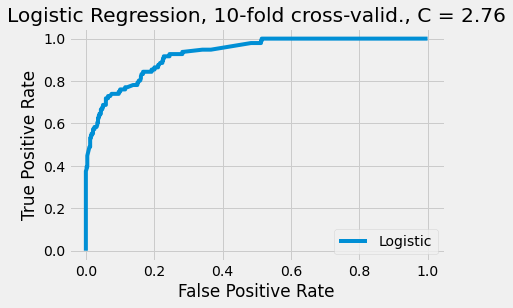

AUC: 0.928


In [144]:
prob_cv = lr_cv.predict_proba(X_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test, prob_cv, pos_label=1, drop_intermediate=False)
plt.plot(fpr, tpr, linestyle='-', label='Logistic')
plt.title(f'Logistic Regression, 10-fold cross-valid., C = {C_opt}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.legend()
plt.show();
print('AUC: %.3f' % roc_auc_score(y_test, prob_cv))

Manual ROC curve with controllable no. of threshold probabilities.

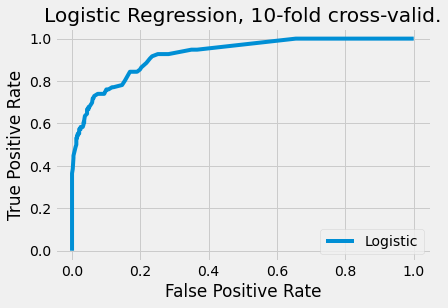

AUC: 0.928


In [145]:
pred_prob = lr_cv.predict_proba(X_test) # probability of y=0 (1st column) and y=1 (2nd column)
prob_step = 0.01
fpr = np.empty(int(1+1/prob_step))
tpr = np.empty(int(1+1/prob_step))
j = 0 # counter of points
thresholds = np.arange(0, 1+prob_step, prob_step)
for prob_thresh in thresholds:
    tn = 0; fn = 0; tp = 0; fp = 0;
    for i in range(pred_prob.shape[0]): # each test case
        if pred_prob[i,1] >= prob_thresh: # classify as 1
            if y_test[i] == 0: # actual 0
                fp = fp+1
            else: # actual 1
                tp = tp+1
        else: # classify as 0
            if y_test[i] == 0: # actual 0
                tn = tn+1
            else: # actual 1
                fn = fn+1
    fpr[j] = fp/(tn + fp) # specificity
    tpr[j] = tp/(tp + fn) # sensitivity
    j = j+1
#print("FPR =",fpr)
#print("TPR =",fpr)
# ROC curve
plt.plot(fpr, tpr, linestyle='-', label='Logistic')
plt.title('Logistic Regression, 10-fold cross-valid.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print('AUC: %.3f' % roc_auc_score(y_test, pred_prob[:,1]))

In [147]:
print("Performance for a given decision threshold")
#from sklearn.metrics import accuracy_score, recall_score, precision_score
THRESHOLD = 0.5
preds = np.where(pred_prob[:,1] > THRESHOLD, 1, 0)
pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"], columns=['Score'])

Performance for a given decision threshold


,Score
accuracy,0.907666
recall,0.583333
precision,0.811594
roc_auc_score,0.778068


### Optimize decision threshold

In [149]:
# calculate the squared g-mean for each threshold
gmeans_sq = tpr * (1-fpr)
# locate the index of the largest g-mean
ix = np.argmax(gmeans_sq)
print('Best Threshold = %.4f, G-Mean_sq = %.4f' % (thresholds[ix], gmeans_sq[ix]))
print('FPR = %.4f, TPR = %.4f' % (fpr[ix], tpr[ix]))

Best Threshold = 0.0700, G-Mean_sq = 0.7019
FPR = 0.2343, TPR = 0.9167


In [150]:
#from sklearn.metrics import accuracy_score, recall_score, precision_score
preds = np.where(pred_prob[:,1] > thresholds[ix], 1, 0)
pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"], columns=['Score'])

,Score
accuracy,0.790941
recall,0.916667
precision,0.440000
roc_auc_score,0.841179


### Optimize solver

In [ ]:
optCV_C_rocauc(0.1, 100, 0.1, solver='newton-cg')

In [ ]:
print('Optimize C using 10-fold cross-validation, lbfgs solver')
log_reg_lbfgs = LogisticRegression(solver='lbfgs')
accuracy = pd.DataFrame({'C':[],'Accuracy':[]})
acc_opt = 0
for C in np.arange(0.1, 100.0, 0.1):
    C = round(C,1)
    log_reg_cv_lbfgs = LogisticRegression(solver='lbfgs', C=C, random_state=0, max_iter=3000)
    scores = cross_val_score(log_reg_cv_lbfgs, X_train, y_train, cv=10) # accuracies of cv cross-validations
    acc = scores.mean()
    accuracy = accuracy.append({'C':C,'Accuracy':acc}, ignore_index=True)
    if acc_opt < acc:
        acc_opt = acc
        C_opt = C
    #if C % 10 == 0: print("C =",C)
print('Optimal C =',C_opt)
print('Highest accuracy =',acc_opt)
plt.scatter(accuracy['C'],accuracy['Accuracy']);
plt.xlabel('C');
plt.ylabel('Accuracy');

In [ ]:
print('Optimize C using 10-fold cross-validation, lbfgs solver')
log_reg_lbfgs = LogisticRegression(solver='lbfgs')
accuracy = pd.DataFrame({'C':[],'Accuracy':[]})
acc_opt = 0
for C in np.arange(0.01, 10.01, 0.01):
    #C = round(C,1)
    log_reg_cv_lbfgs = LogisticRegression(solver='lbfgs', C=C, random_state=0, max_iter=3000)
    scores = cross_val_score(log_reg_cv_lbfgs, X_train, y_train, cv=10) # accuracies of cv cross-validations
    acc = scores.mean()
    accuracy = accuracy.append({'C':C,'Accuracy':acc}, ignore_index=True)
    if acc_opt < acc:
        acc_opt = acc
        C_opt = C
    #if C % 10 == 0: print("C =",C)
print('Optimal C =',C_opt)
print('Highest accuracy =',acc_opt)
plt.scatter(accuracy['C'],accuracy['Accuracy']);
plt.xlabel('C');
plt.ylabel('Accuracy');

In [ ]:
C_opt=0.04
log_reg_cv_lbfgs = LogisticRegression(solver='lbfgs', C=C_opt, random_state=0, max_iter=3000)
log_reg_cv_lbfgs.fit(X_test, y_test)
scores = cross_val_score(log_reg_cv_lbfgs, X_train, y_train, cv=10) # accuracies of cv cross-validations
acc = scores.mean()
print("Accuracy =",acc)
prob_cv_lbfgs = log_reg_cv_lbfgs.predict_proba(X_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test, prob_cv_lbfgs, pos_label=1, drop_intermediate=False)

In [ ]:
### Optimize decision threshold
# calculate the squared g-mean for each threshold
gmeans_sq = tpr*(1-fpr)
# locate the index of the largest g-mean
ix = np.argmax(gmeans_sq)
print('Best Threshold=%.4f, G-Mean_sq=%.4f' % (thresh[ix], gmeans_sq[ix]))
print('FPR=%.4f, TPR=%.4f' % (fpr[ix], tpr[ix]))

from sklearn.metrics import accuracy_score, recall_score, precision_score
THRESHOLD = thresh[ix]
preds = np.where(log_reg_cv.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])